In [1]:
import numpy as np
import torch
import logging
import json
import os
import re
from datetime import datetime
from pathlib import Path

import pdfplumber
from pdf2image import convert_from_path
import pytesseract

import docx
import cv2

import spacy
from transformers import pipeline
print(np.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용하는 장치: {device}")

c:\Users\user\anaconda3\envs\parser\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.24.3
사용하는 장치: cuda


In [2]:
class CVParser:
    def __init__(self, model_name="facebook/bart-large-mnli"):
        try:
            np.array([1, 2, 3])
        except Exception as e:
            raise RuntimeError("NumPy is not properly installed or accessible") from e

        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

        import warnings
        warnings.filterwarnings("ignore", category=FutureWarning)
        warnings.filterwarnings("ignore", category=UserWarning)

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.logger.info(f"Using device: {self.device}")

        try:
            self.nlp = spacy.load("en_core_web_lg")
        except OSError:
            self.logger.info("Downloading spacy model...")
            os.system("python -m spacy download en_core_web_lg")
            self.nlp = spacy.load("en_core_web_lg")

        try:
            self.classifier = pipeline(
                "zero-shot-classification",
                model=model_name,
                model_kwargs={"device_map": "auto"}
            )
            self.logger.info("Successfully initialized transformer models")
        except Exception as e:
            self.logger.error(f"Error initializing transformer models: {str(e)}")
            raise

        self.patterns = {
            'email': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
            'phone': r'\b\d{2,4}[-.)]\d{3,4}[-.)]\d{4}\b',
            'date': r'\b\d{4}[-/]\d{1,2}[-/]\d{1,2}\b|\b\d{1,2}[-/]\d{1,2}[-/]\d{4}\b',
            'education_keywords': r'\b(university|college|school|bachelor|master|phd|degree)\b',
            'experience_keywords': r'\b(experience|work|job|position|company|role)\b'
        }

        self.section_labels = [
            "Personal Information",
            "Education",
            "Work Experience",
            "Skills",
            "Projects",
            "Certifications",
            "Languages",
            "Interests"
        ]

    def parse(self, file_path):
        try:
            if not os.path.exists(file_path):
                raise FileNotFoundError(f"File not found: {file_path}")

            file_path = Path(file_path)
            ext = file_path.suffix.lower().lstrip('.')

            if not ext:
                raise ValueError(f"File has no extension: {file_path}")

            supported_formats = {
                'pdf': self._extract_from_pdf,
                'docx': self._extract_from_docx,
                'doc': self._extract_from_docx
            }

            if ext not in supported_formats:
                raise ValueError(f"Unsupported file format: {ext}")

            text = supported_formats[ext](str(file_path))

            if not text:
                raise ValueError("No text could be extracted from the file")

            parsed_data = {
                'basic_info': self.extract_basic_info(text),
                'sections': self.classify_sections(text),
                'entities': self.extract_entities(text),
                'skills': self.extract_skills(text),
                'education': self.extract_education(text),
                'experience': self.extract_experience(text),
                'metadata': {
                    'parsed_date': datetime.now().isoformat(),
                    'file_name': file_path.name,
                    'file_format': ext
                }
            }

            self._save_results(parsed_data, str(file_path))
            return parsed_data

        except Exception as e:
            self.logger.error(f"Error parsing CV: {str(e)}")
            raise

    def _extract_text(self, file_path, ext):
        supported_formats = {
            'pdf': self._extract_from_pdf,
            'docx': self._extract_from_docx,
            'doc': self._extract_from_docx
        }

        if ext not in supported_formats:
            raise ValueError(f"Unsupported file format: {ext}")

        return supported_formats[ext](file_path)

    def _extract_from_pdf(self, file_path):
        text = ""
        pdf_path = Path(file_path)
        
        if not pdf_path.exists():
            raise FileNotFoundError(f"PDF file not found: {file_path}")

        try:
            with pdfplumber.open(file_path) as pdf:
                for page in pdf.pages:
                    extracted_text = page.extract_text()
                    if extracted_text:
                        text += extracted_text + "\n"

            if not text.strip():
                self.logger.info("No text extracted from PDF, attempting OCR...")
                return self._try_ocr(file_path)

            return text

        except Exception as e:
            self.logger.error(f"Error in PDF extraction: {str(e)}")
            self.logger.info("Attempting OCR as fallback...")
            return self._try_ocr(file_path)

    def _extract_from_docx(self, file_path):
        try:
            doc = docx.Document(file_path)
            return '\n'.join([paragraph.text for paragraph in doc.paragraphs])
        except Exception as e:
            self.logger.error(f"Error extracting text from DOCX: {str(e)}")
            raise

    def _try_ocr(self, file_path):
        try:
            images = convert_from_path(file_path, dpi=300)
            text_parts = []

            for i, image in enumerate(images):
                self.logger.info(f"Processing page {i+1}")
                
                image_np = np.array(image)
                
                gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
                denoised = cv2.fastNlMeansDenoising(gray)
                _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

                custom_config = r'--oem 3 --psm 6'
                text = pytesseract.image_to_string(binary, config=custom_config)
                text_parts.append(text)

            return '\n'.join(text_parts)

        except Exception as e:
            self.logger.error(f"OCR failed: {str(e)}")
            raise

    def extract_basic_info(self, text):
        info = {
            'name': None,
            'email': None,
            'phone': None,
            'location': None
        }
        
        email_matches = re.findall(self.patterns['email'], text)
        if email_matches:
            info['email'] = email_matches[0]
            
        phone_matches = re.findall(self.patterns['phone'], text)
        if phone_matches:
            info['phone'] = phone_matches[0]
            
        doc = self.nlp(text[:1000])
        for ent in doc.ents:
            if ent.label_ == 'PERSON' and not info['name']:
                info['name'] = ent.text
            elif ent.label_ == 'GPE' and not info['location']:
                info['location'] = ent.text
                
        return info

    def classify_sections(self, text):
        sections = {}
        paragraphs = text.split('\n\n')
        
        for paragraph in paragraphs:
            if len(paragraph.strip()) > 50: 
                result = self.classifier(paragraph, self.section_labels)
                label = result['labels'][0]
                score = result['scores'][0]
                
                if score > 0.5: 
                    sections.setdefault(label, []).append({
                        'text': paragraph,
                        'confidence': score
                    })
                    
        return sections

    def extract_entities(self, text):
        doc = self.nlp(text)
        entities = []
        
        for ent in doc.ents:
            entities.append({
                'text': ent.text,
                'label': ent.label_,
                'start': ent.start_char,
                'end': ent.end_char
            })
            
        return entities

    def extract_skills(self, text):
        skills = []
        tech_keywords = ['python', 'java', 'javascript', 'sql', 'aws', 'docker', 'kubernetes', 'react', 'angular']
        
        for keyword in tech_keywords:
            if re.search(r'\b' + keyword + r'\b', text.lower()):
                skills.append(keyword)
                
        return list(set(skills))

    def extract_education(self, text):
        education = []
        lines = text.split('\n')
        
        for i, line in enumerate(lines):
            if re.search(self.patterns['education_keywords'], line.lower()):
                dates = re.findall(self.patterns['date'], line)
                
                education.append({
                    'text': line.strip(),
                    'dates': dates,
                    'context': '\n'.join(lines[max(0, i-1):min(len(lines), i+2)])
                })
                
        return education

    def extract_experience(self, text):
        experience = []
        lines = text.split('\n')
        
        for i, line in enumerate(lines):
            if re.search(self.patterns['experience_keywords'], line.lower()):
                dates = re.findall(self.patterns['date'], line)
                
                experience.append({
                    'text': line.strip(),
                    'dates': dates,
                    'context': '\n'.join(lines[max(0, i-1):min(len(lines), i+2)])
                })
                
        return experience

    def _save_results(self, parsed_data, original_file_path):
        output_path = original_file_path.rsplit('.', 1)[0] + '_parsed.json'
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(parsed_data, f, ensure_ascii=False, indent=2)

In [3]:
parser = CVParser()

try:
    link = 'data/joannadrummond-cv.pdf'
    if link[-3:] == 'pdf':
        try:
            result_pdf = parser.parse('data/joannadrummond-cv.pdf')
        except Exception as e:
            print(f"Error: {e}")
        print("Basic Info:", result_pdf['basic_info'])
        print("Skills:", result_pdf['skills'])
    
    else: 
        result_docx = parser.parse('path_to_cv.docx')
        print("Education:", result_docx['education'])
        print("Experience:", result_docx['experience'])
    
except Exception as e:
    print(f"Error: {str(e)}")

2024-11-05 09:13:42,181 - __main__ - INFO - Using device: cuda
2024-11-05 09:13:43,923 - accelerate.utils.modeling - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
2024-11-05 09:13:45,008 - __main__ - INFO - Successfully initialized transformer models


Basic Info: {'name': 'Joanna Drummond', 'email': 'jdrummond@cs.toronto.edu', 'phone': None, 'location': 'Rm'}
Skills: ['python', 'java']


In [5]:
print(result_pdf.keys())

dict_keys(['basic_info', 'sections', 'entities', 'skills', 'education', 'experience', 'metadata'])


In [8]:
print(result_pdf['basic_info'])
print(result_pdf['sections'])
print(result_pdf['entities'])
print(result_pdf['skills'])
print(result_pdf['education'])
print(result_pdf['experience'])
print(result_pdf['metadata'])

{'name': 'Joanna Drummond', 'email': 'jdrummond@cs.toronto.edu', 'phone': None, 'location': 'Rm'}
{}
[{'text': 'Joanna Drummond', 'label': 'PERSON', 'start': 0, 'end': 15}, {'text': 'Department of Computer Science\nUniversity of Toronto', 'label': 'ORG', 'start': 16, 'end': 68}, {'text': '10', 'label': 'CARDINAL', 'start': 101, 'end': 103}, {'text': 'King’s College Road', 'label': 'ORG', 'start': 104, 'end': 123}, {'text': 'Rm', 'label': 'GPE', 'start': 125, 'end': 127}, {'text': '3302', 'label': 'DATE', 'start': 129, 'end': 133}, {'text': 'Toronto', 'label': 'GPE', 'start': 134, 'end': 141}, {'text': 'Ontario', 'label': 'GPE', 'start': 143, 'end': 150}, {'text': '3G4', 'label': 'CARDINAL', 'start': 156, 'end': 159}, {'text': 'Canada', 'label': 'GPE', 'start': 160, 'end': 166}, {'text': 'PhD Computer Science', 'label': 'ORG', 'start': 177, 'end': 197}, {'text': 'University of Toronto', 'label': 'ORG', 'start': 199, 'end': 220}, {'text': 'Spring 2017', 'label': 'DATE', 'start': 233, 'en

## Omniparser


현재 위치: c:\Users\user\Desktop\Code\GJS\JobPT
변경된 위치: c:\Users\user\Desktop\Code\GJS\JobPT\OmniParser


Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.



image 1/1 c:\Users\user\Desktop\Code\GJS\JobPT\OmniParser\imgs\saved_image_demo.png: 640x480 14 0s, 35.0ms
Speed: 3.0ms preprocess, 35.0ms inference, 59.1ms postprocess per image at shape (1, 3, 640, 480)
Parsed Screen Elements:
Text Box ID 0: E-Commerce Recommendation System is the first project I've taken on Kakao Corp. Therefore I got through a lot of
Text Box ID 1: moving the applications and batch jobs on bare-metal servers to Apache Mesos framework and then Mesos to Kubernetes.
Text Box ID 2: This project also gave me a lot of valuable lessons about huge data handling systems like batch jobs, Hadoop file system,
Text Box ID 3: HBase, Redis, Spark and real time API deployments.
Text Box ID 4: Work Experience
Text Box ID 5: 2022
Text Box ID 6: Machine Learning Engineer @Daangn, Seoul, S.Korea
Text Box ID 7: 2021-2022
Text Box ID 8: Software Engineer @LINE+, Bundang, S.Korea
Text Box ID 9: LINE+ ML Service Platform team is developing a recommendation system for LINE VOOM.
Text Box 

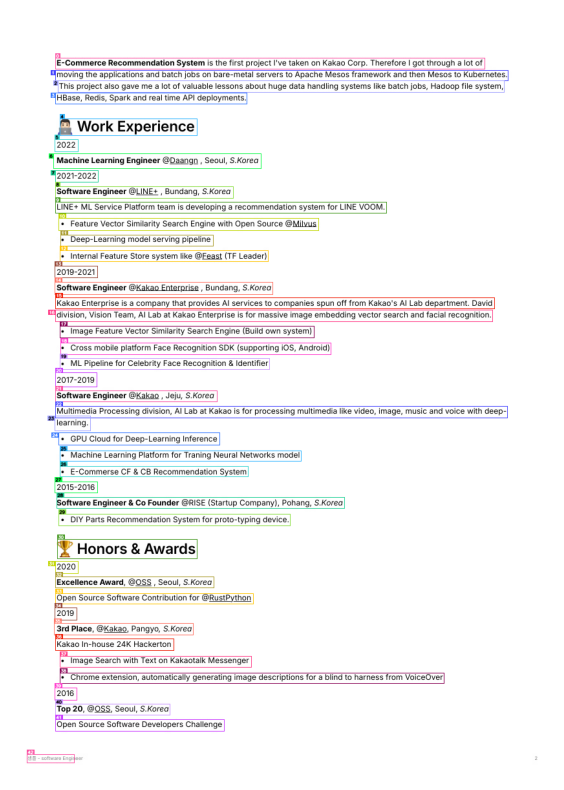

현재 위치: c:\Users\user\Desktop\Code\GJS\JobPT\OmniParser
변경된 위치: c:\Users\user\Desktop\Code\GJS\JobPT


In [2]:
import os
print("현재 위치:", os.getcwd())

if str(os.getcwd()[-10:]) != "OmniParser":
    os.chdir('OmniParser')
    print("변경된 위치:", os.getcwd())

from typing import Optional
import numpy as np
import torch
from PIL import Image
import io
import base64
import os
import matplotlib.pyplot as plt

from utils import check_ocr_box, get_yolo_model, get_caption_model_processor, get_som_labeled_img

yolo_model = get_yolo_model(model_path='weights/icon_detect/best.pt')
caption_model_processor = get_caption_model_processor(
    model_name="florence2", model_name_or_path="weights/icon_caption_florence"
)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def process(
    image_input,
    box_threshold=0.05,
    iou_threshold=0.1,
    use_paddleocr=True,
    imgsz=640
) -> Optional[Image.Image]:
    image_save_path = 'imgs/saved_image_demo.png'
    os.makedirs('imgs', exist_ok=True)
    image_input.save(image_save_path)
    image = Image.open(image_save_path)
    box_overlay_ratio = image.size[0] / 3200
    draw_bbox_config = {
        'text_scale': 0.8 * box_overlay_ratio,
        'text_thickness': max(int(2 * box_overlay_ratio), 1),
        'text_padding': max(int(3 * box_overlay_ratio), 1),
        'thickness': max(int(3 * box_overlay_ratio), 1),
    }

    ocr_bbox_rslt, is_goal_filtered = check_ocr_box(
        image_save_path,
        display_img=False,
        output_bb_format='xyxy',
        goal_filtering=None,
        easyocr_args={'paragraph': False, 'text_threshold': 0.9},
        use_paddleocr=use_paddleocr
    )
    text, ocr_bbox = ocr_bbox_rslt

    dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(
        image_save_path,
        yolo_model,
        BOX_TRESHOLD=box_threshold,
        output_coord_in_ratio=True,
        ocr_bbox=ocr_bbox,
        draw_bbox_config=draw_bbox_config,
        caption_model_processor=caption_model_processor,
        ocr_text=text,
        iou_threshold=iou_threshold,
        imgsz=imgsz
    )
    image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
    parsed_content_list = '\n'.join(parsed_content_list)
    return image, parsed_content_list

box_threshold = 0.05 
iou_threshold = 0.1 
use_paddleocr = True 
imgsz = 640

image_path = "../data/sample_page_2.jpg"
image_input = Image.open(image_path).convert('RGB')

output_image, parsed_content = process(
    image_input,
    box_threshold,
    iou_threshold,
    use_paddleocr,
    imgsz
)

print('Parsed Screen Elements:')
print(parsed_content)

plt.figure(figsize=(10,10))
plt.imshow(output_image)
plt.axis('off')
plt.show()

print("현재 위치:", os.getcwd())

if str(os.getcwd()[-10:]) == "OmniParser":
    os.chdir('..')
    print("변경된 위치:", os.getcwd())


In [ ]:
lines = parsed_content.split('\n')

texts = []
for line in lines:
    if ':' in line:
        text = line.split(':', 1)[1].strip()
        texts.append(text)

processed_texts = []
i = 0
while i < len(texts):
    text = texts[i]
    if text.endswith('-'):
        text = text[:-1]
        if i + 1 < len(texts):
            text += texts[i + 1]
            i += 1
    processed_texts.append(text)
    i += 1

combined_text = ' '.join(processed_texts)

import re
sentence_endings = re.compile(r'(?<=[.!?]) +')
sentences = sentence_endings.split(combined_text)

paragraphs = []
current_paragraph = ''
for sentence in sentences:
    headings = ['Education', 'Publications', 'Honors', 'Relevant Courses', 'GPA', 'Advisor', 'Minor', 'Email', 'Research Advisor']
    if any(heading in sentence for heading in headings):
        if current_paragraph:
            paragraphs.append(current_paragraph.strip())
        current_paragraph = sentence.strip() + ' '
    else:
        current_paragraph += sentence.strip() + ' '

if current_paragraph:
    paragraphs.append(current_paragraph.strip())

for para in paragraphs:
    print(para)
    print('\n')


Joanna Drummond Department of Computer Science University of Toronto Email:jdrummond@cs.toronto. edu 10 King's College Road, Rm.


3302 Toronto, Ontario, M5S 3G4 Canada Education PhD Computer Science, University of Toronto, (expected) Spring 2017.


Co-advisors: Allan Borodin, Kate Larson Achieved Candidacy: Spring 2015 Relevant Courses: Algorithms for Solving Propositional Theories; Intro to Graph Theory; Topics in Knowledge Representation and Reasoning; Advanced Microeconomic Theory I GPA: 3.83 M.S. Computer Science, University of Toronto, Spring 2013.


Advisor: Craig Boutilier Relevant Courses: Decision Making under Uncertainty; Advanced Inference Algorithms; Algorithm Design, Analysis, and Theory GPA: 3.93 B.S. Computer Science and Mathematics, University of Pittsburgh, December 2010.


Research Advisor: Diane Litman Minor: Theatre Arts.


Honors: Graduated Magna Cum Laude with Departmental Honors; Dean's List, Fall 2006 to Spring 2010; Dean's Stars List, Spring 2007; Upsilon Pi E

In [1]:
import fitz  # PyMuPDF
import os

def convert_pdf_to_jpg(pdf_path, output_folder):
    try:
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        pdf_filename = os.path.splitext(os.path.basename(pdf_path))[0]
        doc = fitz.open(pdf_path)

        for i in range(doc.page_count):
            page = doc.load_page(i)  
            pix = page.get_pixmap()
            output_file = os.path.join(output_folder, f'{pdf_filename}_page_{i+1}.jpg')
            pix.save(output_file)
            print(f'페이지 {i+1}을(를) 저장했습니다: {output_file}')
        
        print(f'변환 완료! 총 {doc.page_count} 페이지를 변환했습니다.')
    
    except Exception as e:
        print(f'에러가 발생했습니다: {str(e)}')

pdf_path = "data/sample.pdf"
output_folder = "data"
convert_pdf_to_jpg(pdf_path, output_folder)


페이지 1을(를) 저장했습니다: data\sample_page_1.jpg
페이지 2을(를) 저장했습니다: data\sample_page_2.jpg
페이지 3을(를) 저장했습니다: data\sample_page_3.jpg
변환 완료! 총 3 페이지를 변환했습니다.
